BLOCO 1 — Imports e Configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

BLOCO 2 — Carregar Dataset (df e y)

In [3]:
path = "dataset/LSVT_voice_rehabilitation.xlsx"
df = pd.read_excel(path, sheet_name="Data")
y = pd.read_excel(path, sheet_name="Binary response")
y = y.iloc[:, 0]

print("Dimensões do df:", df.shape)
print("Dimensões de y:", y.shape)

df.head(), y.head()


Dimensões do df: (126, 310)
Dimensões de y: (126,)


(   Jitter->F0_abs_dif  Jitter->F0_dif_percent  \
 0            0.088112                0.041697   
 1            0.161798                0.057364   
 2            0.554508                0.642913   
 3            0.031089                0.027108   
 4            0.076177                0.039071   
 
    Jitter->F0_PQ5_classical_Schoentgen  Jitter->F0_PQ5_classical_Baken  \
 0                             0.000480                   -3.723304e-06   
 1                             0.000677                    5.466365e-06   
 2                             0.007576                   -7.443871e-07   
 3                             0.000314                   -2.214722e-07   
 4                             0.000302                    2.732106e-05   
 
    Jitter->F0_PQ5_generalised_Schoentgen  Jitter->F0_abs0th_perturb  \
 0                               0.000422                   2.458381   
 1                               0.000206                   2.592066   
 2                            

BLOCO 3 — Distribuição das Classes

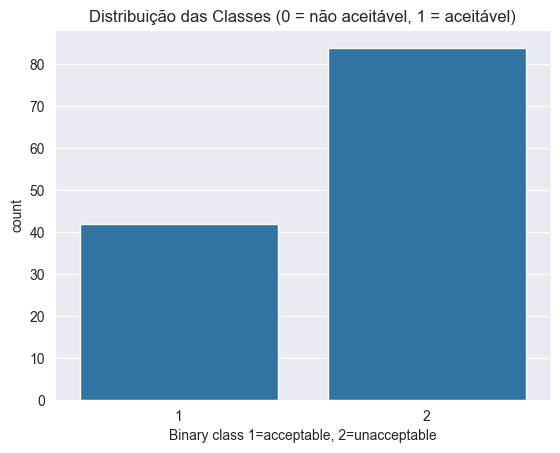

In [4]:
sns.countplot(x=y)
plt.title("Distribuição das Classes (0 = não aceitável, 1 = aceitável)")
plt.show()


BLOCO 4 — Normalização dos Dados

In [5]:
scaler = StandardScaler()
# Normalização é essencial para SVM, pois ele é sensível à escala das features
X_scaled = scaler.fit_transform(df)

BLOCO 5 — PCA (Visualização 2D)

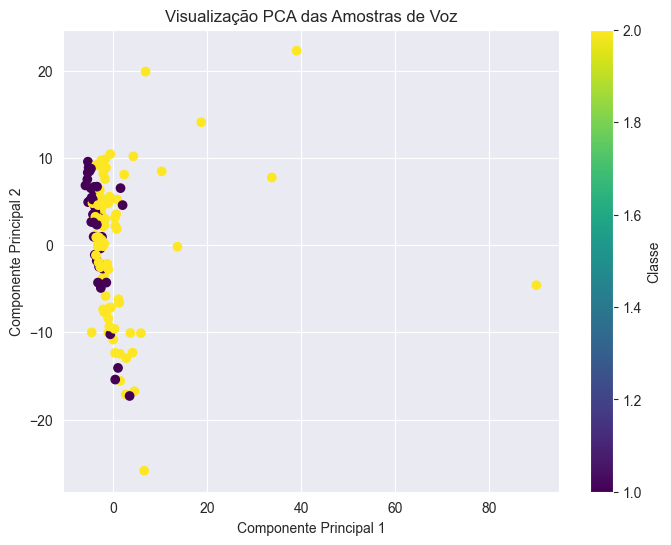

In [6]:
# PCA com 2 componentes apenas para visualização (não usado no treinamento)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="viridis")
plt.title("Visualização PCA das Amostras de Voz")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Classe")
plt.show()


BLOCO 6 — Separação Treino/Teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

BLOCO 7 — Treinamento com SVM (Validação Cruzada)

In [8]:
svm = SVC(kernel="rbf")

# Validação cruzada com 5 folds para medir estabilidade do modelo
scores = cross_val_score(svm, X_train, y_train, cv=5)

print("Acurácia média (Validação Cruzada):", scores.mean())


Acurácia média (Validação Cruzada): 0.8608187134502925


BLOCO 8 — Busca dos Melhores Hiperparâmetros (GridSearch)

In [9]:
param_grid = {
    "C": [0.1, 1, 10, 50, 100],
    "gamma": ["scale", 0.01, 0.001]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)


,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


BLOCO 9 — Avaliação Final no Teste

In [10]:
# O dataset original marca as classes como 1 e 2 → converter para {0,1} para compatibilidade com métricas como ROC/AUC
y = y.replace({1: 0, 2: 1})

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

# probability=True é necessário para decision_function / curva ROC
svm = SVC(probability=True)
grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_

print("Melhores parâmetros:", grid.best_params_)


Melhores parâmetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


BLOCO 10 — Matriz de Confusão

Acurácia do modelo SVM: 0.8438


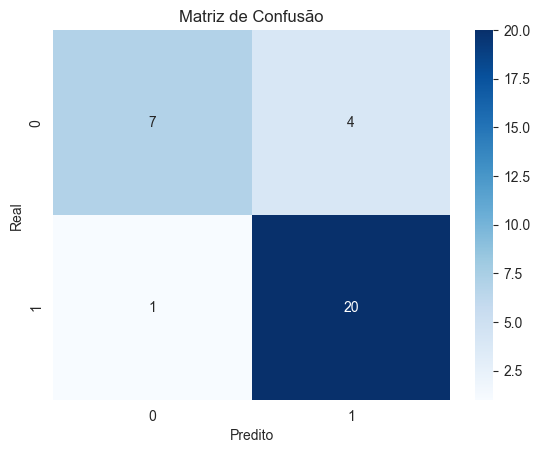

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.83      0.95      0.89        21

    accuracy                           0.84        32
   macro avg       0.85      0.79      0.81        32
weighted avg       0.85      0.84      0.84        32



In [11]:
# Predições
y_pred = best_svm.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo SVM: {acc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Relatório Completo
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))


BLOCO 11 — Curva ROC

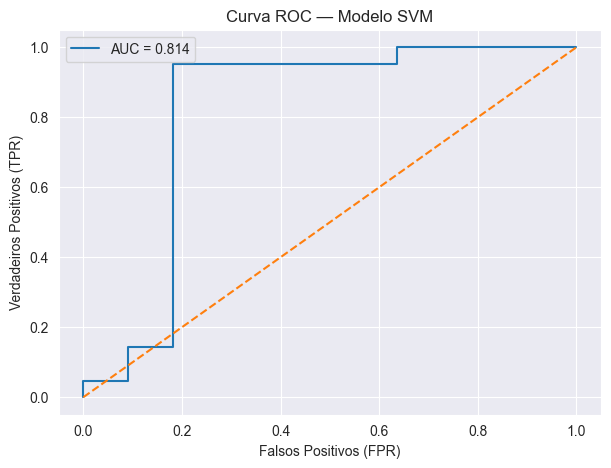

In [12]:
# Scores contínuos (necessário para ROC)
y_scores = best_svm.decision_function(X_test)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], '--')
plt.legend()
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdadeiros Positivos (TPR)")
plt.title("Curva ROC — Modelo SVM")
plt.show()
